In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)


# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 서비스 계정 키 경로 설정
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"/home/eunyu/sprintda05-eunyu-a9946f7dea9c.json"

# GCS의 Parquet 파일 경로
gcs_path = 'gs://final_project_enuyu/data/final_project/votes/accounts_pointhistory.parquet'

# 데이터 불러오기
pointhistory_df = pd.read_parquet(gcs_path, engine='pyarrow')
pointhistory_df

,id,delta_point,created_at,user_id,user_question_record_id
0,790629,9,2023-04-28 12:27:49,849436,771777.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0
...,...,...,...,...,...
2338913,340672371,14,2024-05-08 01:35:02,855509,161666462.0
2338914,340672372,11,2024-05-08 01:36:00,855525,161666463.0
2338915,340672373,11,2024-05-08 01:36:00,855526,161666463.0
2338916,340672374,12,2024-05-08 01:36:18,855525,161666464.0


In [17]:
pointhistory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338918 entries, 0 to 2338917
Data columns (total 5 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   delta_point              int64         
 2   created_at               datetime64[ns]
 3   user_id                  int64         
 4   user_question_record_id  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 89.2 MB


In [18]:
pointhistory_df.isnull().sum()

id                            0
delta_point                   0
created_at                    0
user_id                       0
user_question_record_id    2992
dtype: int64

In [19]:
pointhistory_df.describe(include='all')

,id,delta_point,created_at,user_id,user_question_record_id
count,2.338918e+06,2.338918e+06,2338918,2.338918e+06,2.335926e+06
mean,1.265364e+08,8.610862e-01,2023-05-18 03:06:43.825683968,1.111554e+06,6.141803e+07
min,7.906290e+05,-1.000000e+03,2023-04-28 12:27:49,8.380230e+05,7.717770e+05
25%,4.112505e+07,7.000000e+00,2023-05-11 04:37:02,8.861890e+05,2.088561e+07
50%,1.123971e+08,1.000000e+01,2023-05-16 07:29:11,1.126012e+06,5.540614e+07
75%,1.982051e+08,1.300000e+01,2023-05-22 13:47:48.750000128,1.260221e+06,9.555855e+07
max,3.406724e+08,1.000000e+03,2024-05-08 01:36:18,1.583358e+06,1.616665e+08
std,9.610992e+07,5.885849e+01,NaN,2.024429e+05,4.531970e+07


In [6]:
# 고유 사용자 수
unique_users = pointhistory_df['user_id'].nunique()
print(f"총 고유 사용자 수: {unique_users}")

총 고유 사용자 수: 5037


#### delta_point 분포

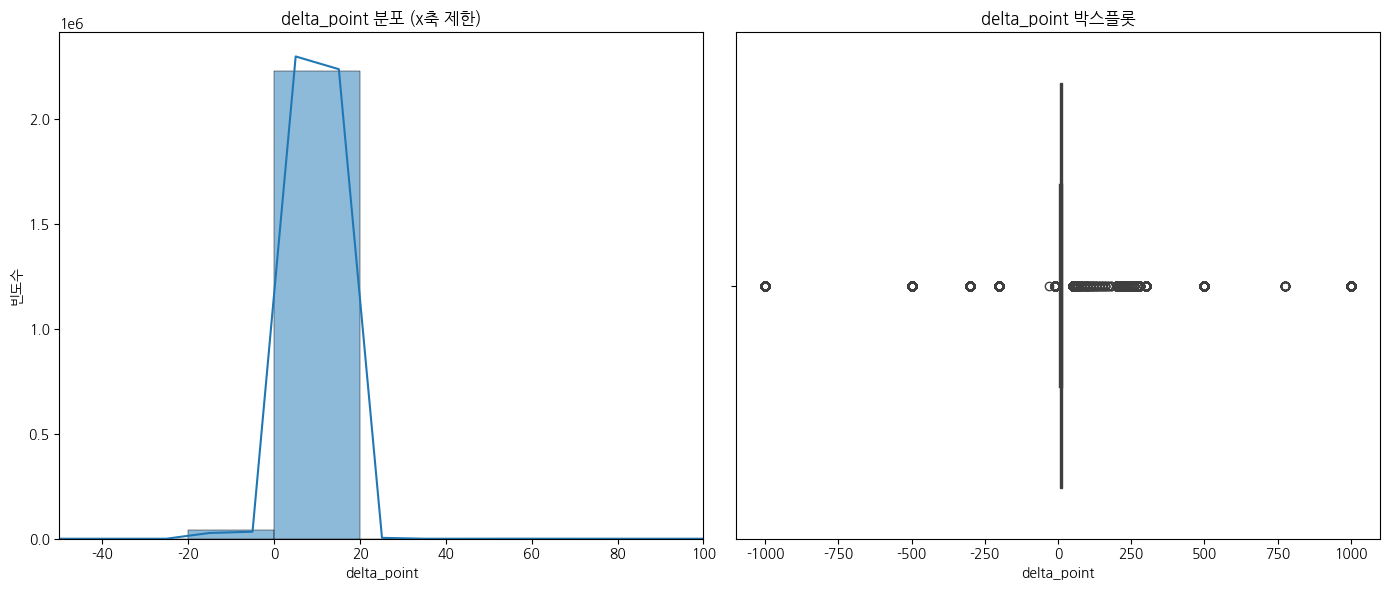

In [7]:
plt.figure(figsize=(14, 6))

# 히스토그램 (x축 범위 제한)
plt.subplot(1, 2, 1)
sns.histplot(pointhistory_df['delta_point'], bins=100, kde=True)
plt.xlim(-50, 100)  # 범위 조정
plt.title('delta_point 분포 (x축 제한)')
plt.xlabel('delta_point')
plt.ylabel('빈도수')

# 박스플롯 (범위 제한 없이 그대로)
plt.subplot(1, 2, 2)
sns.boxplot(x=pointhistory_df['delta_point'])
plt.title('delta_point 박스플롯')
plt.xlabel('delta_point')

plt.tight_layout()
plt.show()


1. 전체 분포 (x축 제한 후)
- 대부분의 delta_point는 0 ~ 20 사이에 집중
- 극단적인 음수/양수 값은 존재하지만, 빈도는 거의 없음
- +10 또는 +13과 같은 특정 포인트 지급 패턴이 있을 것으로 추정됨
          
2. 박스플롯에서 본 이상치
- 수많은 극단값(outlier) 존재:
   - 음수: -1000, -500 등
   - 양수: 1000 이상도 있음
 - 전체 데이터에 비해 빈도는 작지만, 시스템적으로 정책/이벤트적 의미가 있을 가능성 큼

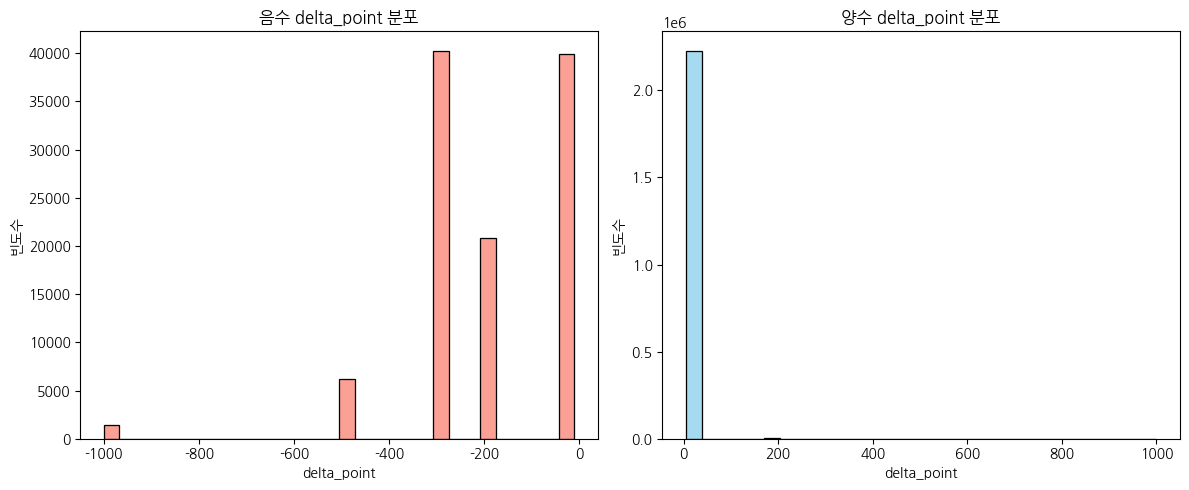

In [8]:
plt.figure(figsize=(12, 5))

# 음수
plt.subplot(1, 2, 1)
sns.histplot(pointhistory_df[pointhistory_df['delta_point'] < 0]['delta_point'], bins=30, color='salmon')
plt.title('음수 delta_point 분포')
plt.xlabel('delta_point')
plt.ylabel('빈도수')

# 양수
plt.subplot(1, 2, 2)
sns.histplot(pointhistory_df[pointhistory_df['delta_point'] > 0]['delta_point'], bins=30, color='skyblue')
plt.title('양수 delta_point 분포')
plt.xlabel('delta_point')
plt.ylabel('빈도수')

plt.tight_layout()
plt.show()


1. 음수 분포
- -10, -100, -200, -300, -1000 등 특정 구간에 몰림
- 특히 -300, -200, -100이 눈에 띔 → 벌점 또는 제재성 포인트 차감으로 추정
- 매우 큰 음수 (-1000)는 소수의 특이 이벤트
           
2. 양수 분포
- 대부분 0 ~ 20 사이에서 발생
- 1000 같은 큰 양수도 존재하지만 매우 드묾
- 일괄적으로 지급되는 보상 구조일 가능성

#### 양수(보상) / 음수(차감) 그룹으로 나누고, 유저 행동 비교

In [9]:
# 양수/음수 그룹 나누기
positive_df = pointhistory_df[pointhistory_df['delta_point'] > 0]
negative_df = pointhistory_df[pointhistory_df['delta_point'] < 0]

# 유저별 포인트 변화 요약
positive_summary = positive_df.groupby('user_id')['delta_point'].agg(['count', 'sum']).rename(columns={'count': 'pos_count', 'sum': 'pos_sum'})
negative_summary = negative_df.groupby('user_id')['delta_point'].agg(['count', 'sum']).rename(columns={'count': 'neg_count', 'sum': 'neg_sum'})

# 유저 기준으로 병합
user_behavior = positive_summary.join(negative_summary, how='outer').fillna(0)
user_behavior['total_events'] = user_behavior['pos_count'] + user_behavior['neg_count']

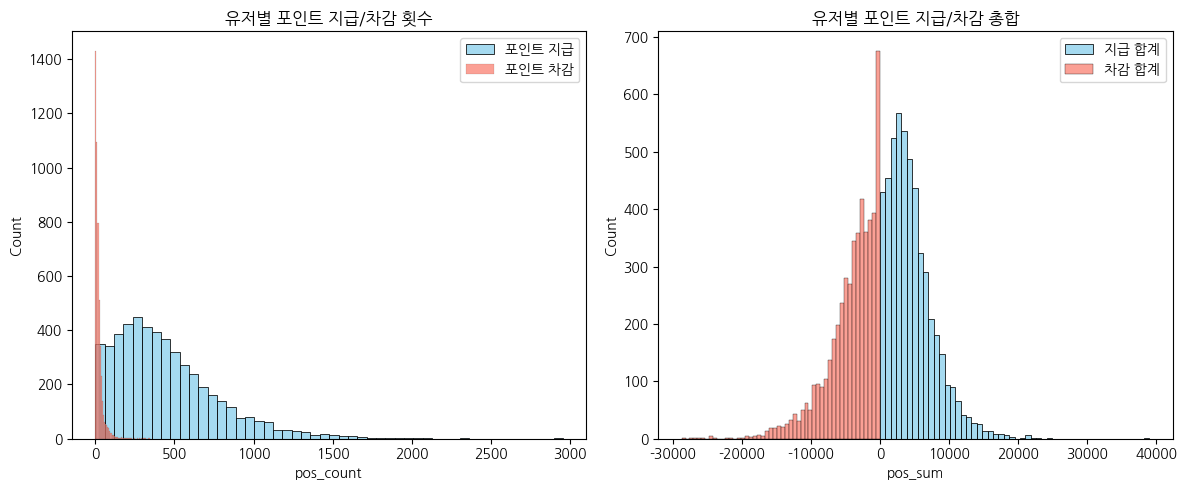

In [10]:


plt.figure(figsize=(12, 5))

# 포인트 지급/차감 이벤트 수 비교
plt.subplot(1, 2, 1)
sns.histplot(user_behavior['pos_count'], bins=50, color='skyblue', label='포인트 지급')
sns.histplot(user_behavior['neg_count'], bins=50, color='salmon', label='포인트 차감')
plt.legend()
plt.title('유저별 포인트 지급/차감 횟수')

# 포인트 총합 비교
plt.subplot(1, 2, 2)
sns.histplot(user_behavior['pos_sum'], bins=50, color='skyblue', label='지급 합계')
sns.histplot(user_behavior['neg_sum'], bins=50, color='salmon', label='차감 합계')
plt.legend()
plt.title('유저별 포인트 지급/차감 총합')

plt.tight_layout()
plt.show()


1. 유저별 포인트 지급/차감 횟수
- 대다수 유저는 0~100회 미만의 차감만 경험     
→ 포인트 차감은 제한된 유저에게만 반복적으로 발생함                 
- 반면 지급 횟수는 훨씬 분산되어 있음           
→ 보상은 다양한 유저에게 빈번하게 발생함               
→ 일부 유저는 수백~수천 건의 포인트 획득             

- 포인트 지급은 전반적으로 활성화된 활동 시스템의 일환            
                       
- 차감은 특정 유저 중심의 제한적 발생 → 제재성 가능성 있음



2. 유저별 지급/차감 총합
- 지급 합계는 0~10,000 사이에 정규분포에 가까운 모양
- 차감 합계는 왼쪽으로 긴 꼬리 (long left tail) 형태
→ 일부 유저는 -30,000점 이상까지 차감당함       
→ 벌점 누적, 악성 행동 반복 등 가능성               
                         



- 보상은 일정한 기준에 따라 균형 있게 분포됨
                 
- 차감은 소수 유저에 집중된 과도한 패널티일 수 있음

#### 사용자별 누적 포인트 변화량 집계

In [11]:
# user_id별 누적 delta_point 합계 계산
user_point_balance = pointhistory_df.groupby('user_id')['delta_point'].sum().reset_index()
user_point_balance.columns = ['user_id', 'total_delta_point']

# 상위 10명 (가장 많은 포인트 획득)
top_users = user_point_balance.sort_values(by='total_delta_point', ascending=False).head(10)

# 하위 10명 (가장 많은 포인트 차감 또는 손실)
bottom_users = user_point_balance.sort_values(by='total_delta_point', ascending=True).head(10)

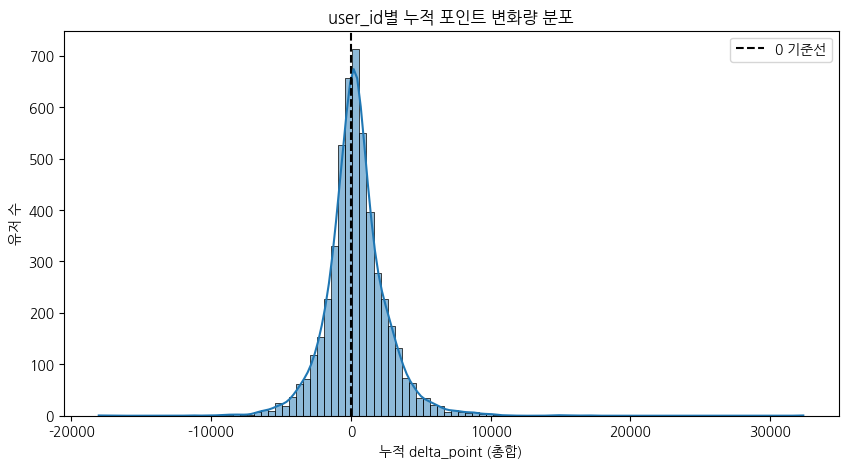

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(user_point_balance['total_delta_point'], bins=100, kde=True)
plt.title('user_id별 누적 포인트 변화량 분포')
plt.xlabel('누적 delta_point (총합)')
plt.ylabel('유저 수')
plt.axvline(0, color='black', linestyle='--', label='0 기준선')
plt.legend()
plt.show()

- 대부분 유저는 -5,000 ~ +10,000 범위 내 활동
- -10,000 이상 차감된 유저는 소수지만 존재 → 제재성 활동/벌점 가능성

In [13]:
print("포인트 누적 상위 유저 Top 10")
print(top_users)

print("\n포인트 누적 하위 유저 Bottom 10")
print(bottom_users)


포인트 누적 상위 유저 Top 10
      user_id  total_delta_point
21     849103              32378
1895   952220              16967
2269  1058255              15696
1623   896512              14834
4170  1370056              14608
561    873568              11285
3173  1188527              10533
3968  1306868              10229
1774   922680               9975
2176  1038004               9965

포인트 누적 하위 유저 Bottom 10
      user_id  total_delta_point
1276   885409             -18043
3137  1185764             -11322
3391  1217035             -10003
2838  1152814              -9180
2226  1045301              -8897
4261  1385822              -8770
4620  1445986              -8295
3332  1210808              -8255
3467  1227266              -8181
3271  1204866              -7722


1. 포인트 누적 상위 유저 Top 10
- 최대 +32,378점까지 누적 보상 받은 유저 존재
- 다수 유저가 1만 점 이상 보유 → 시스템 내에서 긍정적 활동 반복 유저로 추정
- user_id = 21, 849103번 유저가 가장 많은 누적 보상

2. 포인트 누적 하위 유저 Bottom 10
- 최저 -18,043점까지 누적 차감
- user_id = 1276, 885409번 유저가 가장 큰 손실
- 공통점: 대부분 -8,000 ~ -18,000 구간           
→ 악성/문제 유저, 시스템적 차감 등 가능성 있음



In [14]:
# 상위 10명 user_id 리스트
top_user_ids = top_users['user_id'].tolist()

# 해당 유저들의 포인트 이력 추출
top_user_points = pointhistory_df[pointhistory_df['user_id'].isin(top_user_ids)]

# 양수만 분석 (보상만)
positive_points = top_user_points[top_user_points['delta_point'] > 0]

# 지급 포인트 값의 빈도수
event_point_counts = positive_points['delta_point'].value_counts().sort_values(ascending=False)
print(event_point_counts.head(20))  # 상위 20개 값


delta_point
5       1484
7       1483
10      1461
12      1450
11      1441
14      1433
8       1430
13      1424
15      1418
9       1394
6       1358
300       84
200       16
50         6
500        6
210        5
60         4
230        4
1000       4
220        4
Name: count, dtype: int64


### 2023년 5~7월 포인트 기록

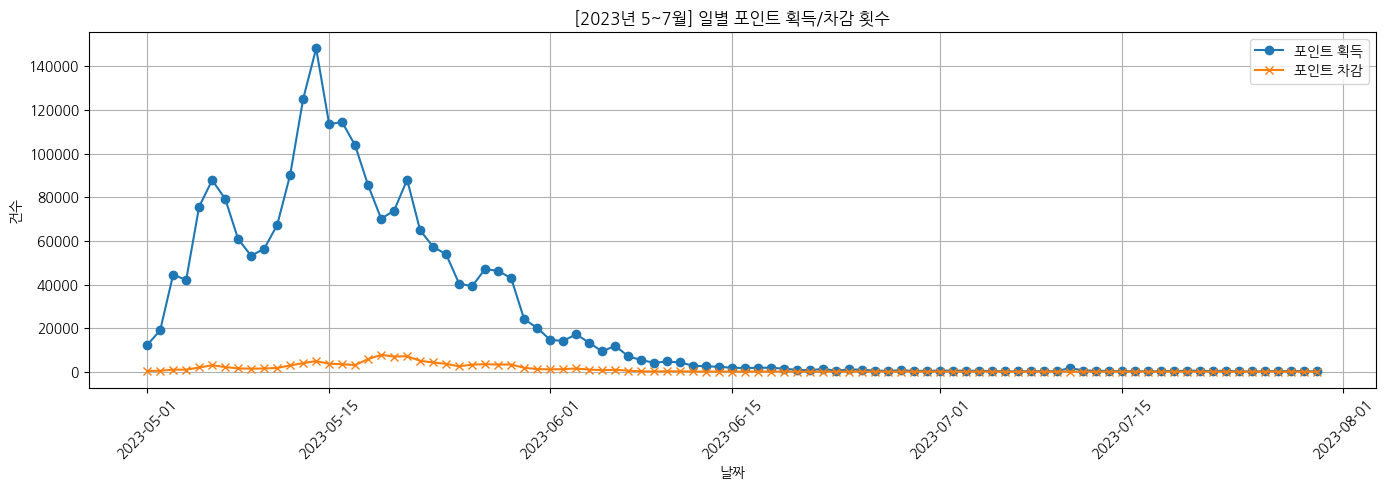

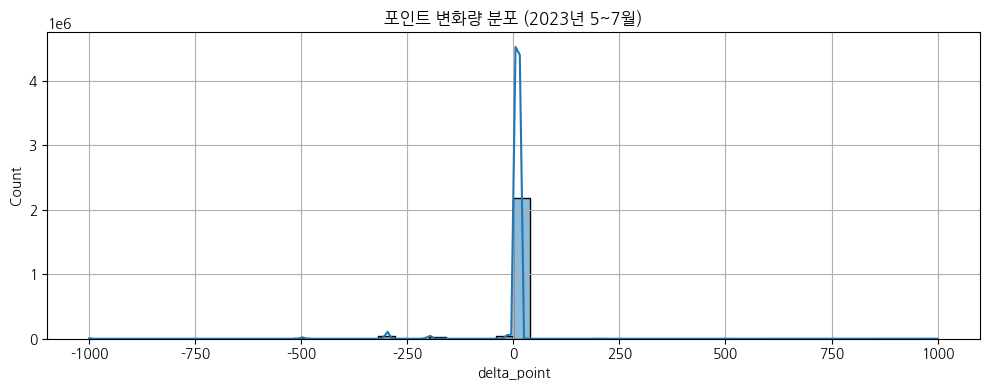

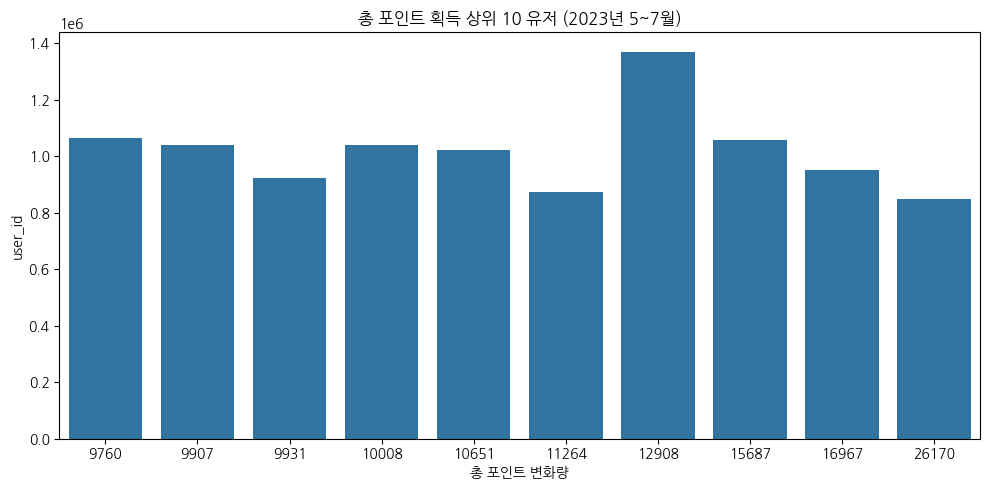

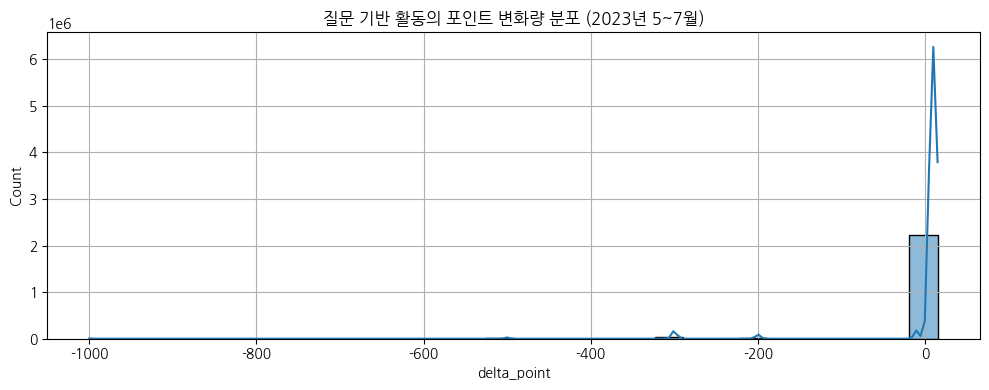

In [20]:

# 날짜 변환
pointhistory_df['created_at'] = pd.to_datetime(pointhistory_df['created_at'])

# 분석 기간 필터링: 2023-05-01 ~ 2023-07-31
mask = (pointhistory_df['created_at'] >= '2023-05-01') & (pointhistory_df['created_at'] <= '2023-07-31')
df = pointhistory_df[mask].copy()
df['date'] = df['created_at'].dt.date

# 1. 일별 포인트 획득/차감 횟수 추이
daily_gain = df[df['delta_point'] > 0].groupby('date').size()
daily_loss = df[df['delta_point'] < 0].groupby('date').size()

plt.figure(figsize=(14, 5))
plt.plot(daily_gain.index, daily_gain.values, label='포인트 획득', marker='o')
plt.plot(daily_loss.index, daily_loss.values, label='포인트 차감', marker='x')
plt.title('[2023년 5~7월] 일별 포인트 획득/차감 횟수')
plt.xlabel('날짜')
plt.ylabel('건수')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 포인트 변화량 분포
plt.figure(figsize=(10, 4))
sns.histplot(df['delta_point'], bins=50, kde=True)
plt.title('포인트 변화량 분포 (2023년 5~7월)')
plt.xlabel('delta_point')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 유저별 총 포인트 변화량 상위 10명
top_users = df.groupby('user_id')['delta_point'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_users.values, y=top_users.index)
plt.title('총 포인트 획득 상위 10 유저 (2023년 5~7월)')
plt.xlabel('총 포인트 변화량')
plt.ylabel('user_id')
plt.tight_layout()
plt.show()

# 4. 질문 기반 참여(user_question_record_id 존재)의 포인트 변화량
q_df = df[df['user_question_record_id'].notna()]
plt.figure(figsize=(10, 4))
sns.histplot(q_df['delta_point'], bins=30, kde=True)
plt.title('질문 기반 활동의 포인트 변화량 분포 (2023년 5~7월)')
plt.xlabel('delta_point')
plt.grid(True)
plt.tight_layout()
plt.show()


질문 기반 활동도 대부분 +10 전후의 포인트 → 투표/답변과 연관된 기본 보상 추정.

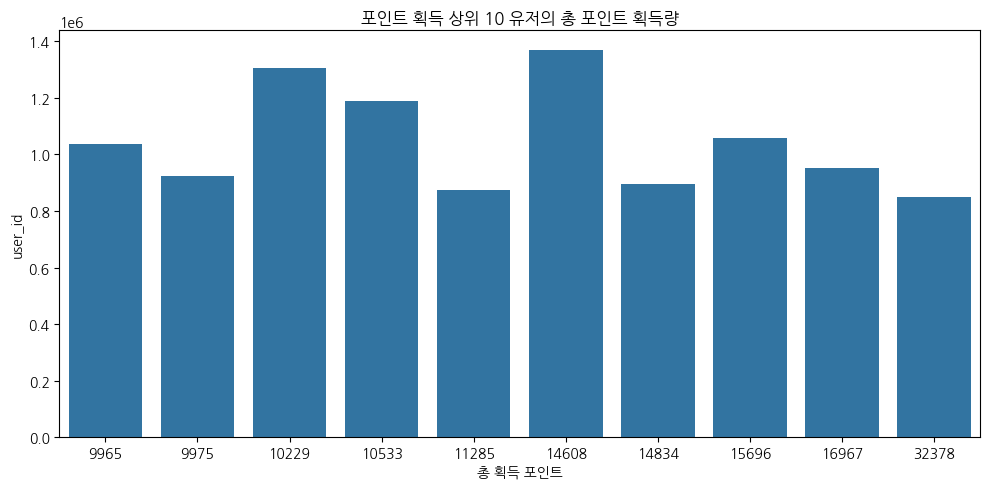

user_id
849103     32378
952220     16967
1058255    15696
896512     14834
1370056    14608
873568     11285
1188527    10533
1306868    10229
922680      9975
1038004     9965
Name: delta_point, dtype: int64

In [5]:


# 유저별 포인트 총합 계산
top_point_users = pointhistory_df.groupby('user_id')['delta_point'].sum().sort_values(ascending=False).head(10)

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x=top_point_users.values, y=top_point_users.index)
plt.title('포인트 획득 상위 10 유저의 총 포인트 획득량')
plt.xlabel('총 획득 포인트')
plt.ylabel('user_id')
plt.tight_layout()
plt.show()


top_point_users

In [11]:


# 1. 포인트 상위 유저 top 10명 추출
top_users = pointhistory_df.groupby('user_id')['delta_point'].sum().sort_values(ascending=False).head(10).index.tolist()

# 2. 상위 유저의 전체 로그 추출
top_df = pointhistory_df[pointhistory_df['user_id'].isin(top_users)].copy()
top_df['created_at'] = pd.to_datetime(top_df['created_at'])

# 3. 유저별 행동 시퀀스 정렬
top_df = top_df.sort_values(['user_id', 'created_at'])

# 4. 세션 분리 (30분 이상 gap이면 새로운 세션으로 정의)
top_df['prev_time'] = top_df.groupby('user_id')['created_at'].shift(1)
top_df['time_diff'] = (top_df['created_at'] - top_df['prev_time']).dt.total_seconds() / 60  # in minutes
top_df['new_session'] = (top_df['time_diff'] > 30) | (top_df['time_diff'].isna())
top_df['session_id'] = top_df.groupby('user_id')['new_session'].cumsum()

# 5. 각 세션별 활동 수, 포인트 합계 요약
session_summary = top_df.groupby(['user_id', 'session_id']).agg(
    session_start=('created_at', 'min'),
    session_end=('created_at', 'max'),
    actions=('id', 'count'),
    total_points=('delta_point', 'sum')
).reset_index()

# 6. 특정 유저의 시퀀스 로그 확인 예시
example_user = top_users[4]
example_seq = top_df[top_df['user_id'] == example_user][['created_at', 'delta_point', 'session_id']]

display(example_seq.head(20))


,created_at,delta_point,session_id
1399930,2023-05-18 10:13:35,8,1
1401275,2023-05-18 10:35:26,10,1
1401483,2023-05-18 10:37:27,12,1
1408658,2023-05-18 12:16:53,15,2
1422784,2023-05-18 14:04:51,12,3
1422807,2023-05-18 14:04:58,5,3
1431920,2023-05-18 15:04:37,5,4
1431974,2023-05-18 15:04:52,15,4
1433967,2023-05-18 15:20:35,6,4
1440409,2023-05-18 16:36:36,11,5


In [13]:
# 1. 포인트 상위 유저 top 10명 중 네 번째 유저
example_user = top_users[4]
print(f"분석 대상 유저 ID: {example_user}")

# 2. 해당 유저의 세션 요약 데이터 필터링
user_sessions = session_summary[session_summary['user_id'] == example_user].copy()

# 3. 세션 개수 확인
total_sessions = user_sessions['session_id'].nunique()
print(f"총 세션 수: {total_sessions}개")

# 4. 세션별 요약 정보 출력
display(user_sessions.sort_values('session_id'))

분석 대상 유저 ID: 1370056
총 세션 수: 180개


,user_id,session_id,session_start,session_end,actions,total_points
2290,1370056,1,2023-05-18 10:13:35,2023-05-18 10:37:27,3,30
2291,1370056,2,2023-05-18 12:16:53,2023-05-18 12:16:53,1,15
2292,1370056,3,2023-05-18 14:04:51,2023-05-18 14:04:58,2,17
2293,1370056,4,2023-05-18 15:04:37,2023-05-18 15:20:35,3,26
2294,1370056,5,2023-05-18 16:36:36,2023-05-18 16:37:48,6,45
...,...,...,...,...,...,...
2465,1370056,176,2023-06-26 10:34:18,2023-06-26 10:35:31,10,97
2466,1370056,177,2023-06-28 15:02:21,2023-06-28 15:03:32,10,92
2467,1370056,178,2023-07-13 10:14:31,2023-07-13 10:15:35,8,76
2468,1370056,179,2023-07-24 17:20:07,2023-07-24 17:20:07,1,200


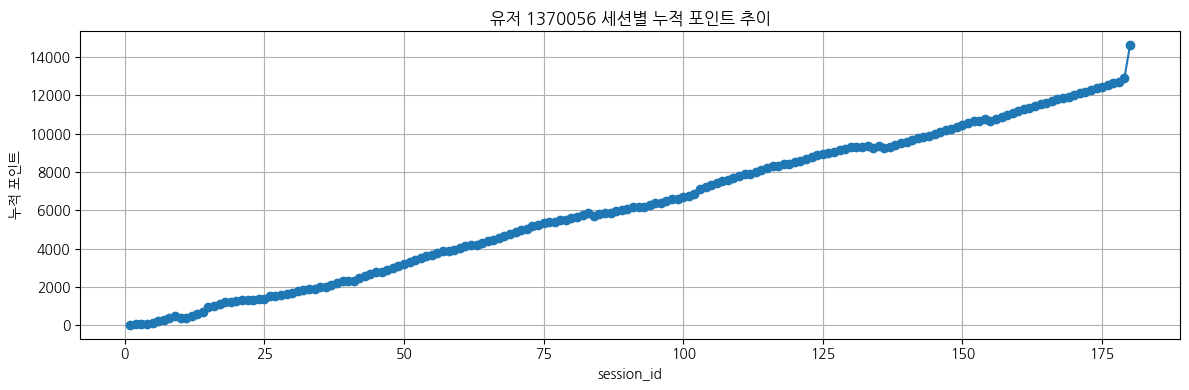

In [18]:
user_sessions = session_summary[session_summary['user_id'] == 1370056].sort_values('session_id')
user_sessions['cumulative_points'] = user_sessions['total_points'].cumsum()



plt.figure(figsize=(12, 4))
plt.plot(user_sessions['session_id'], user_sessions['cumulative_points'], marker='o')
plt.title('유저 1370056 세션별 누적 포인트 추이')
plt.xlabel('session_id')
plt.ylabel('누적 포인트')
plt.grid(True)
plt.tight_layout()
plt.show()


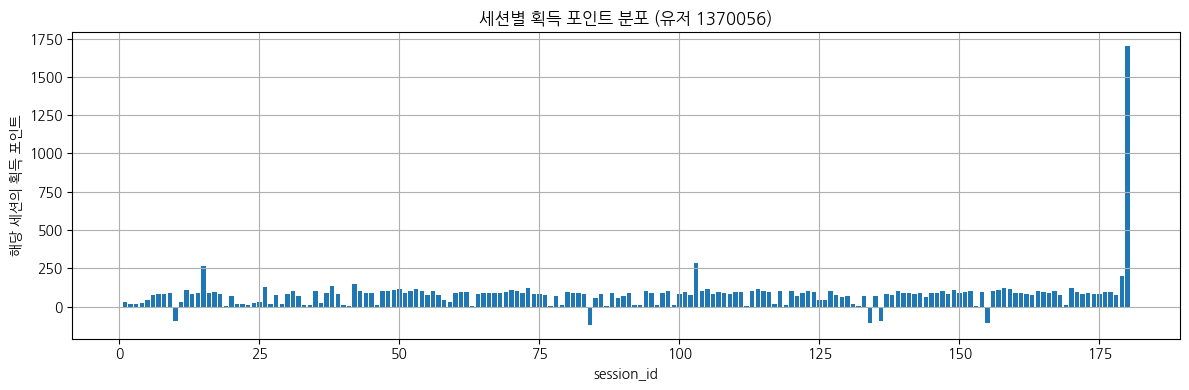

In [19]:
plt.figure(figsize=(12, 4))
plt.bar(user_sessions['session_id'], user_sessions['total_points'])
plt.title('세션별 획득 포인트 분포 (유저 1370056)')
plt.xlabel('session_id')
plt.ylabel('해당 세션의 획득 포인트')
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# 1. 포인트가 정확히 1700인 행 필터링
df_1700 = pointhistory_df[pointhistory_df['delta_point'] == 1700].copy()
df_1700['created_at'] = pd.to_datetime(df_1700['created_at'])
df_1700['date'] = df_1700['created_at'].dt.date

# 2. 유저 1370056이 받은 날짜 확인
target_user_date = df_1700[df_1700['user_id'] == 1370056]['date'].unique()
print("1370056 유저가 1700pt를 받은 날짜:", target_user_date)

# 3. 같은 날짜에 다른 유저가 1700pt 받은 경우 찾기
others = df_1700[
    (df_1700['user_id'] != 1370056) &
    (df_1700['date'].isin(target_user_date))
]

# 4. 결과 출력
print(f"\n해당 날짜에 1700pt 받은 다른 유저 수: {others['user_id'].nunique()}명")
display(others[['user_id', 'created_at']].sort_values('created_at'))


1370056 유저가 1700pt를 받은 날짜: []

해당 날짜에 1700pt 받은 다른 유저 수: 0명


,user_id,created_at


In [14]:
# 각 세션에서 발생한 delta_point 순서 저장
seq_df = top_df.groupby(['user_id', 'session_id'])['delta_point'].apply(list).reset_index(name='point_sequence')

# 시퀀스 길이 및 반복성
seq_df['sequence_length'] = seq_df['point_sequence'].apply(len)
seq_df['unique_values'] = seq_df['point_sequence'].apply(lambda x: len(set(x)))
seq_df['repetition_ratio'] = seq_df['unique_values'] / seq_df['sequence_length']  # 1에 가까울수록 다양함


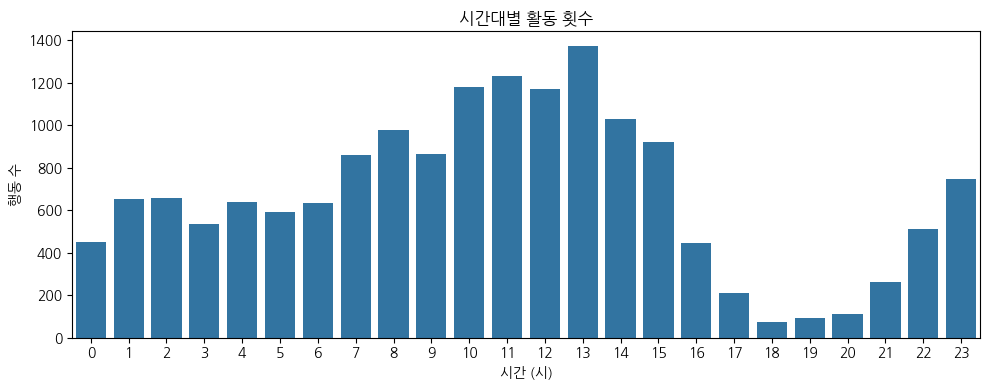

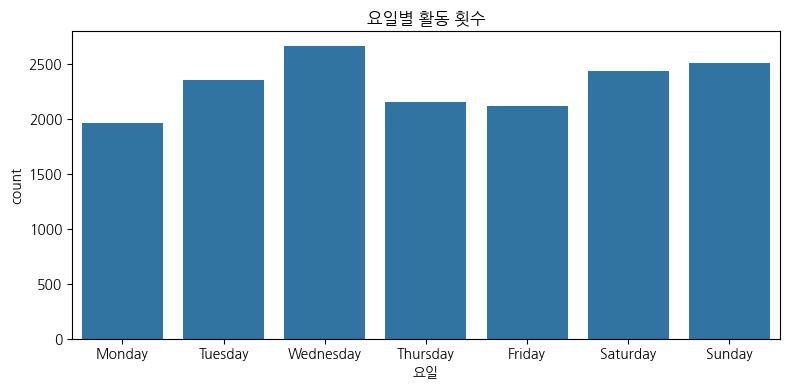

In [15]:
top_df['hour'] = top_df['created_at'].dt.hour
top_df['weekday'] = top_df['created_at'].dt.day_name()

# 시간대별 활동
plt.figure(figsize=(10, 4))
sns.countplot(data=top_df, x='hour')
plt.title('시간대별 활동 횟수')
plt.xlabel('시간 (시)')
plt.ylabel('행동 수')
plt.tight_layout()
plt.show()

# 요일별 활동
plt.figure(figsize=(8, 4))
sns.countplot(data=top_df, x='weekday', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('요일별 활동 횟수')
plt.xlabel('요일')
plt.tight_layout()
plt.show()


In [16]:
# 유저별 delta_point 고유값 수
diversity_df = top_df.groupby('user_id')['delta_point'].nunique().reset_index(name='unique_point_types')

# 유저별 대표 보상 Top 3
top_types = top_df.groupby(['user_id', 'delta_point']).size().reset_index(name='count')
top3_each = top_types.groupby('user_id').apply(lambda x: x.sort_values('count', ascending=False).head(3)).reset_index(drop=True)


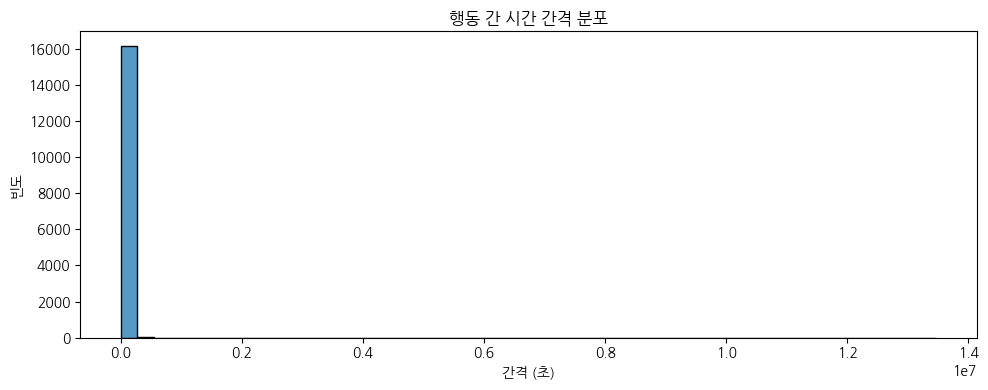

In [17]:
# 시간 간격 히스토그램 (초 단위)
top_df['time_diff'] = top_df.groupby('user_id')['created_at'].diff().dt.total_seconds()

plt.figure(figsize=(10, 4))
sns.histplot(top_df['time_diff'].dropna(), bins=50)
plt.title('행동 간 시간 간격 분포')
plt.xlabel('간격 (초)')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()
